In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee as mc
import arviz as az
# from sklearn.preprocessing import StandardScaler, 

from scipy import stats

## Toy Multiple Regression

$$
y \sim \mathrm{Normal}(\mu_i, \sigma_i) \\
\mu_i = p_0 x_0 + p_1 x_1 \\
p_0 \sim \mathrm{Normal}(0, 1) \\
p_1 \sim \mathrm{Normal}(0, 1)
$$

Where $x_0$, $x_1$ and $y$ are measured with known uncertaintied.

In [2]:
np.random.seed(123)

n = 50
x0 = np.random.uniform(-1, 1, n)
x0_std = 0.01 + np.random.exponential(0.05, n)

x1 = np.random.uniform(-1, 1, n)
x1_std = 0.01 + np.random.exponential(0.05, n)

# x0[-1] = -1
# x1[-1] = 1
# x0_std[-1] = 2
# x1_std[-1] = 2

p0_true = 0.54
p1_true = -0.73

y = p0_true * x0 + p1_true * x1 + np.random.normal(0, 0.05, n)
y_std = 0.01 + np.random.exponential(0.05, n)

# y[-1] = 1
# y_std[-1] = 0.001

Text(0, 0.5, '$x_1$')

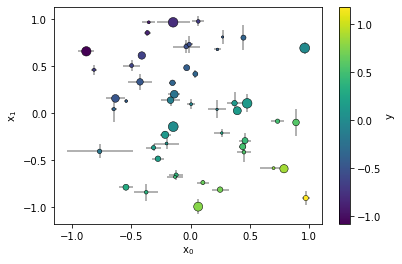

In [3]:
plt.scatter(x0, x1, c=y, s=1/y_std, edgecolor='k', lw=0.5)
plt.errorbar(x0, x1, xerr=x0_std, yerr=x1_std, lw=0, elinewidth=1.5, zorder=-1, c=(0,0,0,0.4))
plt.colorbar(label='y')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

In [67]:
with pm.Model() as m_toy:
    mx0 = pm.Normal('x0', x0, x0_std, shape=len(x0))
    mx1 = pm.Normal('x1', x1, x1_std, shape=len(x1))
    
    p0 = pm.Normal('p0', 0, 1)
    p1 = pm.Normal('p1', 0, 1)
    
    mu = p0 * x0 + p1 * x1
    sigma = pm.Exponential('sigma', 1)  # this is the y ~ N(mu_i, [sigma]) - average mean sigma

    y_pred = pm.Normal('y_pred', mu, y_std, shape=len(y))  # include the meaurement error on the predicted y
    likelihood = pm.Normal('likelihood', y_pred, sigma, observed=y)
        
    trace_toy = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_pred, sigma, p1, p0, x1, x0]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:07<00:00, 419.43draws/s]


In [70]:
# post_pred = pm.sample_posterior_predictive(trace_toy, 1000, m_toy, )['likelihood']
isamples = np.random.randint(0, len(trace_toy) - 1, 1500)
post_pred = (x0.reshape(-1,1) * trace_toy['p0'][isamples] + x1.reshape(-1,1) * trace_toy['p1'][isamples] + np.random.normal(0, trace_toy['sigma'][isamples])).T

(-1, 1)

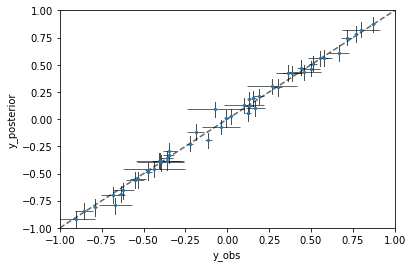

In [71]:
plt.scatter(y, np.median(post_pred, 0), s=5, zorder=3)

plt.errorbar(y, np.median(post_pred, 0), yerr=0, xerr=y_std, lw=0, elinewidth=1, color=(0,0,0,0.6), zorder=2)

# az.plot_hpd(y, post_pred)

plt.xlabel('y_obs')
plt.ylabel('y_posterior')

for o, i in zip(y, az.hpd(post_pred)):
    plt.plot([o,o], i, zorder=-1, lw=1, color=[.3] * 3)

lim = -1, 1
plt.plot(lim, lim, ls='dashed', zorder=-1, color=(0,0,0,0.6))
plt.xlim(lim)
plt.ylim(lim)

## Load Data

In [72]:
# load data from main analysis - carbon chemsitry and uncertainties already calculated
raw = pd.read_csv('Data/compiled_data.csv', header=[0,1], index_col=0)

# individual foram RSD from main analysis - used in plots
ifa_rsd = 0.2554548157013339

In [78]:
# clean up data
dat = pd.DataFrame(columns=['MgCa', 'DIC', 'Ca', 'Temp', 'fMgCa'], index=raw.index)
dat.loc[:, 'MgCa'] = raw.loc[:, ('Measured', 'Mg/Casw')]
dat.loc[:, 'DIC'] = raw.loc[:, ('csys_mid', 'DIC')]
dat.loc[:, 'Ca'] = raw.loc[:, ('Measured', '[Ca]sw')]
dat.loc[:, 'Temp'] = raw.loc[:, ('Measured', 'Temp')]
dat.loc[:, 'fMgCa'] = raw.loc[:, ('Measured', 'Mg/Caf')]
dat.loc[:, 'fMgCa_SE'] = raw.loc[:, ('Uncertainties', 'estimated_SE')]

In [79]:
# # generate synthetic dataset
# nm = 1
# dat = []
# for i, row in raw.iterrows():
#     n = int(row.Measured.numberforams) * nm
#     tmp = pd.DataFrame(columns=['MgCa', 'DIC', 'Ca', 'Temp', 'fMgCa'], index=range(n))
#     tmp.loc[:, 'MgCa'] = stats.norm.rvs(row.loc[('Measured', 'Mg/Casw')], row.loc[('Measured', 'Mg/Casw')] * 0.02, n)
#     tmp.loc[:, 'DIC'] = stats.uniform.rvs(row.loc[('pitzer', 'DIC')], row.loc[('MyAMI', 'DIC')], n)
#     tmp.loc[:, 'Ca'] = stats.norm.rvs(row.loc[('Measured', '[Ca]sw')], row.loc[('Measured', '[Ca]sw')] * .02, n)
#     tmp.loc[:, 'Temp'] = stats.norm.rvs(row.loc[('Measured', 'Temp')], 0.1, n)
#     tmp.loc[:, 'orig_ind'] = i
    
#     tmp.loc[:, 'fMgCa'] = stats.norm.rvs(row.loc[('Measured', 'Mg/Caf')], row.loc[('Measured', 'Mg/Caf')] * ifa_rsd, n)
    
#     dat.append(tmp)
# dat = pd.concat(dat, ignore_index=True)

## Original Data, Linearised

In [95]:
MgCa = np.log(dat.loc[:, 'MgCa'].values.copy())
DIC = np.log(dat.loc[:, 'DIC'].values.copy() * 1e-6)
Ca = dat.loc[:, 'Ca'].values.copy() * 1e-3
Temp = dat.loc[:, 'Temp'].values.copy()

# for v in [MgCa, DIC, Ca, Temp]:
#     v -= v.mean()
#     v /= v.std()

# observed
fMgCa = np.log(dat.loc[:, 'fMgCa'].values.copy())
fMgCa_SE = dat.loc[:, 'fMgCa_SE'].values.copy()
# fMgCa -= fMgCa.mean()
# fMgCa /= fMgCa.std()

In [97]:
with pm.Model() as m_orb:
    # parameters
    A = pm.Normal('A', .8, 0.2)
    B = pm.Normal('B', .8, 0.2)
    C = pm.Normal('C', 20, 10)
    D = pm.Normal('D', 0.09, 0.02)
    E = pm.Normal('E', 0, 0.1)
    
    mu = pm.Deterministic('mu', MgCa * A + DIC * B + C * Ca + D * Temp + E)
    sigma = pm.Exponential('sigma', 1)
    
    p_fMgCa = pm.Normal('p_fMgCa', mu, sigma, observed=fMgCa)
    
    trace_orb = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, E, D, C, B, A]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 176.41draws/s]


In [98]:
post_pred = pm.sample_posterior_predictive(trace_orb, 1000, m_orb)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 768.14it/s]


(0.3, 3)

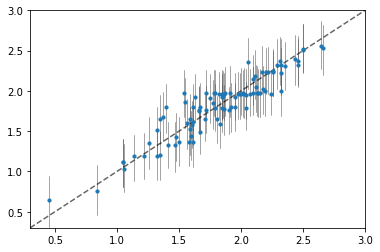

In [100]:
plt.scatter(fMgCa, np.median(trace_orb['mu'], 0), s=10)

for o, i in zip(fMgCa, az.hpd(post_pred['p_fMgCa'])):
    plt.plot([o,o], i, zorder=-1, lw=.5, color=[.3] * 3)
    
lim = 0.3, 3
plt.plot(lim, lim, ls='dashed', zorder=-1, color=(0,0,0,0.6))
plt.xlim(lim)
plt.ylim(lim)

(0, 16)

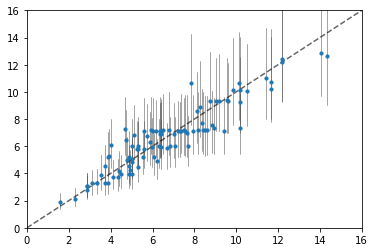

In [101]:
plt.scatter(np.exp(fMgCa), np.exp(np.median(trace_orb[mu], 0)), s=10)

for o, i in zip(np.exp(fMgCa), np.exp(az.hpd(post_pred['p_fMgCa']))):
    plt.plot([o,o], i, zorder=-1, lw=.5, color=[.3] * 3)
    
lim = 0, 16
plt.plot(lim, lim, ls='dashed', zorder=-1, color=(0,0,0,0.6))
plt.xlim(lim)
plt.ylim(lim)

This is working well, but can only fit when target is in mmol/mol... surely should also work in mol/mol?

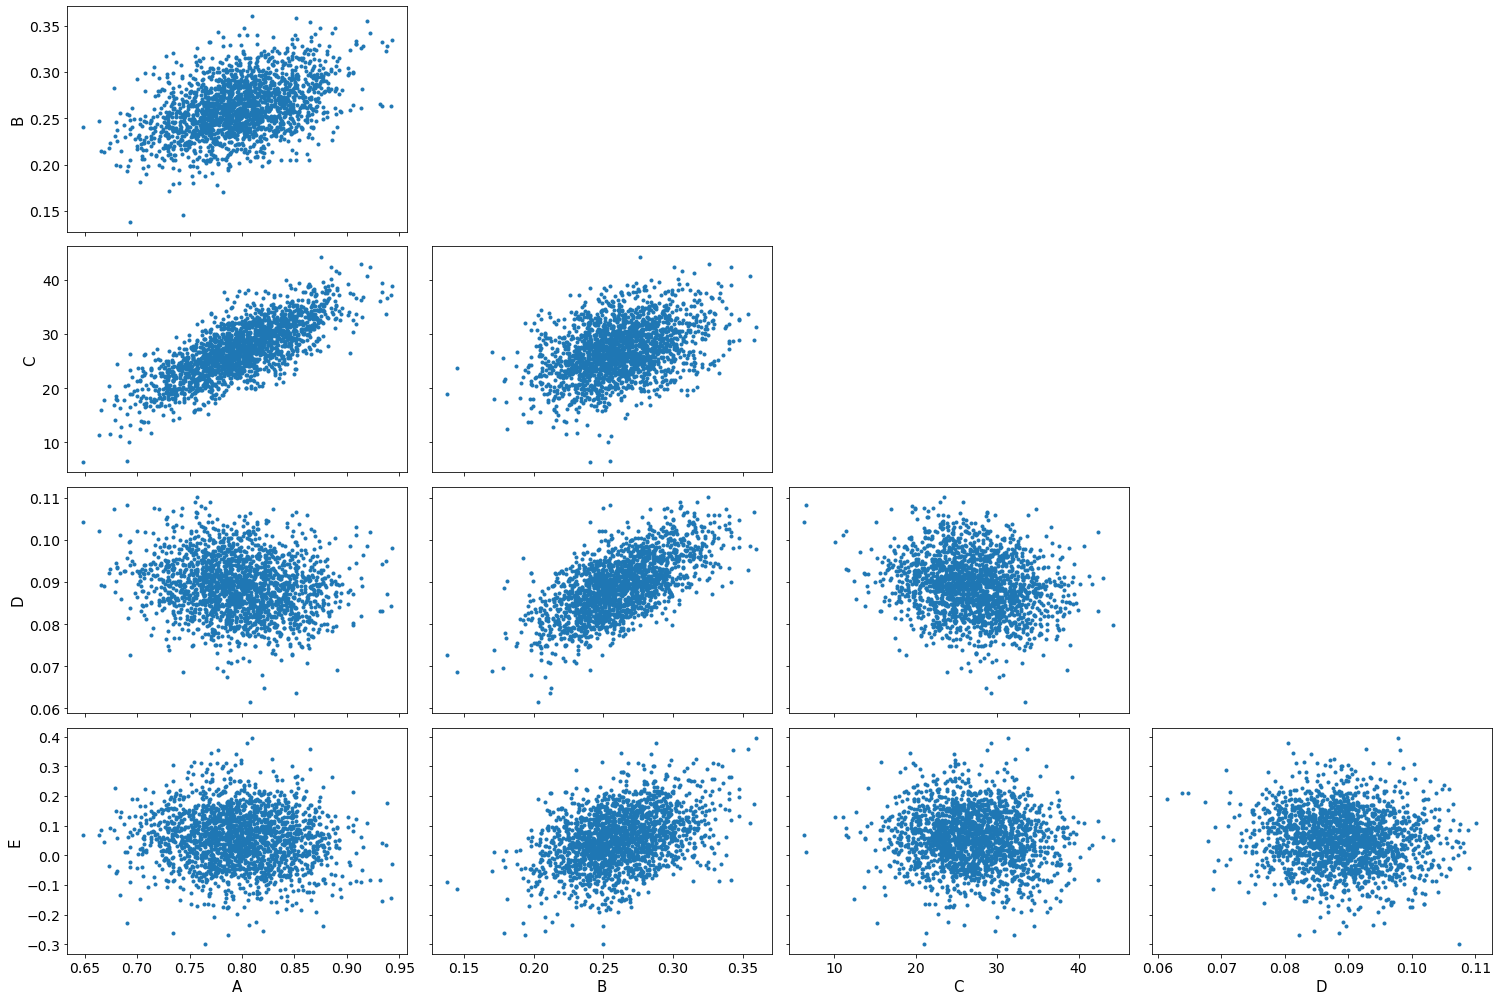

In [102]:
_ = az.plot_pair(trace_orb, var_names=['A', 'B', 'C', 'D', 'E'])

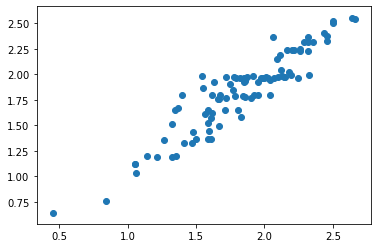

In [105]:
plt.scatter(fMgCa, np.median(trace_orb['mu'], 0))

## Transformed Data

How to log-transform and scale data with uncertainties?

In [61]:
MgCa = np.log(dat.loc[:, ('Measured', 'Mg/Casw')].values.reshape(-1,1))
# s_MgCa = StandardScaler().fit(MgCa)
# z_MgCa = s_MgCa.transform(MgCa)
z_MgCa = np.log(dat.loc[:, ('Measured', 'Mg/Casw')].values)

DIC = np.log(dat.loc[:, ('csys_mid', 'DIC')].values.reshape(-1,1))
# s_DIC = StandardScaler().fit(DIC)
# u_DIC = np.log(dat.loc[:, [('MyAMI', 'DIC'), ('pitzer', 'DIC')]].values)  # lower and upper uniform limits
# z_DIC = s_DIC.transform(u_DIC)
z_DIC = np.log(dat.loc[:, ('csys_mid', 'DIC')].values)

Ca = dat.loc[:, ('Measured', '[Ca]sw')].values.reshape(-1,1)
s_Ca = StandardScaler().fit(Ca)
z_Ca = s_Ca.transform(Ca)[:, 0]

Temp = dat.loc[:, ('Measured', 'Temp')].values.reshape(-1,1)
s_Temp = StandardScaler().fit(Temp)
z_Temp = s_Temp.transform(Temp)[:, 0]

fMgCa = dat.loc[:, ('Measured', 'Mg/Caf')].values.reshape(-1,1)
s_fMgCa = StandardScaler().fit(fMgCa)
z_fMgCa = s_fMgCa.transform(fMgCa)[:, 0]

SE_fMgCa = dat.loc[:, ('Uncertainties', 'estimated_SE')].values #.reshape(-1,1)
z_SE_fMgCa = SE_fMgCa / s_fMgCa.scale_

In [65]:
n = len(z_fMgCa)

with pm.Model() as m_orb:
    # uncertainties
#     d_DIC = pm.Uniform('DIC', *z_DIC.T, shape=n)
#     d_fMgCa = pm.Normal('fMgCa', z_fMgCa, z_SE_fMgCa, shape=z_fMgCa.shape)
    
    # parameters
    A = pm.Normal('A', 0, 0.1)
    B = pm.Normal('B', 0, 0.1)
    C = pm.Normal('C', 0, 0.1)
    D = pm.Normal('D', 0, 0.1)
    E = pm.Normal('E', 0, 0.1)
    
    mu = pm.Deterministic('mu', pm.math.exp(A * z_MgCa + B * z_DIC + C * z_Ca + D * z_Temp + E))
    sigma = pm.Exponential('sigma', 1)
        
    p_fMgCa = pm.Normal('p_fMgCa', mu, z_SE_fMgCa, shape=n)
    likelihood = pm.Normal('like', p_fMgCa, sigma, observed=z_fMgCa)
    
    trace_orb = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_fMgCa, sigma, E, D, C, B, A]
Sampling 2 chains, 52 divergences: 100%|██████████| 3000/3000 [00:10<00:00, 288.29draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [85]:
# with pm.Model() as m_orb:
#     A = pm.Exponential('A', 0.5)
#     B = pm.Exponential('B', 0.5)
#     C = pm.Normal('C', 0, 10)
#     D = pm.Normal('D', 0.07, 0.02)
#     E = pm.Normal('E', 0, 0.1)
#     mu = zMgCa**A * zDIC**B * pm.math.exp(C * zCa + D * zTemp + E)
    
#     mu_est = pm.Normal('mu_est', mu, sigma, shape=len(zMgCa))
#     sigma_est = pm.Exponential('sigma', 1)
    
#     fMgCa = pm.Normal('fMgCa', mu_est, sigma_est, observed=zfMgCa)
    
#     trace_orb = pm.sample(1000)

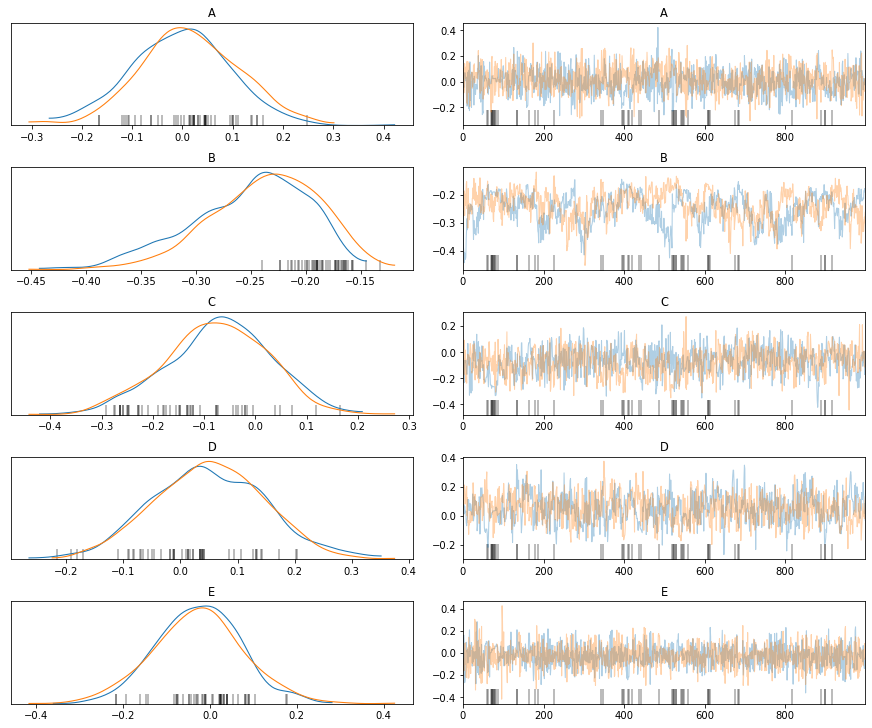

In [66]:
_ = az.plot_trace(trace_orb, var_names=['A', 'B', 'C', 'D', 'E'])

In [72]:
postpred = pm.sample_posterior_predictive(trace_orb, 1000, m_orb)['like']

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1045.10it/s]


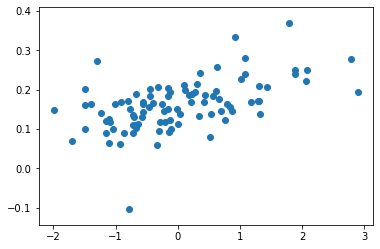

In [75]:
plt.scatter(z_fMgCa, np.median(postpred, 0))

# plt.errorbar(z_fMgCa, np.median(postpred, 0), yerr=0, xerr=sigma, lw=0, elinewidth=1, color=(0,0,0,0.6), zorder=-1)

# for o, i in zip(zfMgCa, az.hpd(postpred)):
#     plt.plot([o,o], i, zorder=-1, lw=1, color=[.3] * 3)

# lim = 0, 16
# plt.plot(lim, lim, ls='dashed', zorder=-1, color=(0,0,0,0.6))
# plt.xlim(lim)
# plt.ylim(lim)

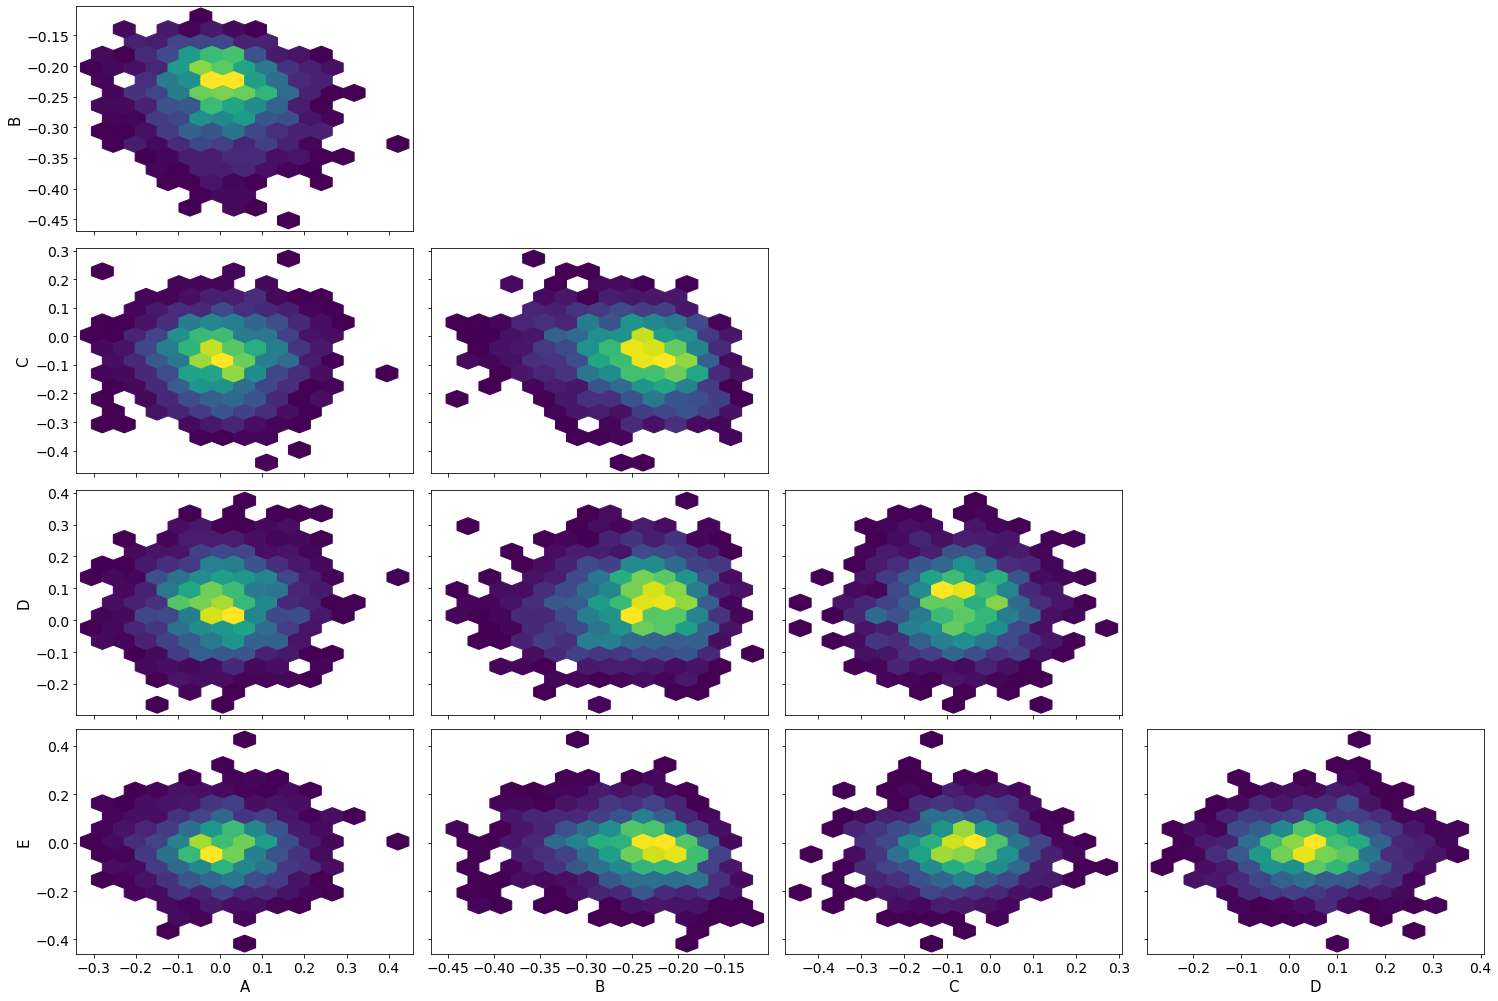

In [76]:
_ = az.plot_pair(trace_orb, var_names=['A', 'B', 'C', 'D', 'E'], kind='hexbin')